# Fusion baseline Model (Ground)

## Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

2025-10-06 11:22:23.413653: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-06 11:22:23.418886: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759767743.424777 1809376 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759767743.426795 1809376 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-06 11:22:23.433677: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

### Config

In [2]:
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

In [3]:
DATA_DIR = Path("../data_processed")
OUT_DIR = Path("../models/05_ground_baseline_model_v1")
OUT_DIR.mkdir(parents=True, exist_ok=True)

TRAIN_PQ = DATA_DIR / "ground_train_h6.parquet"
VAL_PQ = DATA_DIR / "ground_val_h6.parquet"
TEST_PQ = DATA_DIR / "ground_test_h6.parquet"
TARGET = "y_ghi_h6"

FREQ     = "10min"
SEQ_LEN  = 12

### Hyperparameters

In [4]:
BATCH_SIZE = 100
EPOCHS = 50
PATIENCE = 15
LEARNING_RATE = 0.001

### Data loading and preprocessing

In [ ]:
def load_and_preprocess_data():
    """Load and preprocess data for deep learning models"""
    train = pd.read_parquet(TRAIN_PQ)
    val = pd.read_parquet(VAL_PQ)
    test = pd.read_parquet(TEST_PQ)
    
    # if TARGET not in train.columns:
    #     print(f"Advertencia: '{TARGET}' no encontrado en train")
    #     # Buscar columnas similares
    #     target_candidates = [col for col in train.columns if 'y_' in col or 'target' in col.lower()]
    #     print("Posibles columnas objetivo:", target_candidates)
    #     return None

    print(f"Data shapes - Train: {train.shape}, Val: {val.shape}, Test: {test.shape}")
    
    # Remove rows with NaN in target
    train = train.dropna(subset=[TARGET])
    val = val.dropna(subset=[TARGET])
    test = test.dropna(subset=[TARGET])
    
    # Separate features and target
    feat_cols = [c for c in train.columns if c != TARGET]
    
    # Scale features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(train[feat_cols])
    X_val = scaler.transform(val[feat_cols])
    X_test = scaler.transform(test[feat_cols])
    
    y_train = train[TARGET].values
    y_val = val[TARGET].values
    y_test = test[TARGET].values
    
    # Reshape for sequence models (samples, timesteps, features)
    # Using sequence length of 1 for tabular data, but can be extended for time series
    # X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    # X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
    # X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)  # (samples, features, 1)
    X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    return (X_train, y_train, X_val, y_val, X_test, y_test, feat_cols, scaler)

X_train, y_train, X_val, y_val, X_test, y_test, feat_cols, scaler = load_and_preprocess_data()

Data shapes - Train: (57791, 46), Val: (12385, 46), Test: (12384, 46)


## Models

### LSTM

In [6]:
def create_lstm_model(input_shape, units=64, dropout=0.2):
    """Create LSTM model"""
    model = models.Sequential([
        layers.LSTM(units, return_sequences=False, input_shape=input_shape,
                   dropout=dropout, recurrent_dropout=dropout),
        layers.Dense(32, activation='relu'),
        layers.Dropout(dropout),
        layers.Dense(1)
    ])
    return model

### biLSTM

In [7]:
def create_bilstm_model(input_shape, units=64, dropout=0.2):
    """Create Bidirectional LSTM model"""
    model = models.Sequential([
        layers.Bidirectional(layers.LSTM(units, return_sequences=False, 
                                       dropout=dropout, recurrent_dropout=dropout),
                           input_shape=input_shape),
        layers.Dense(32, activation='relu'),
        layers.Dropout(dropout),
        layers.Dense(1)
    ])
    return model

### CNN-LSTM

In [8]:
def create_cnn_lstm_model(input_shape, lstm_units=64, cnn_filters=32, dropout=0.2):
    """Create CNN-LSTM hybrid model"""
    model = models.Sequential([
        # Usar kernel_size=1 o ajustar padding para mantener dimensiones
        layers.Conv1D(cnn_filters, kernel_size=1, activation='relu', 
                     input_shape=input_shape, padding='same'),
        
        # Omitir MaxPooling1D o usar pool_size=1
        # layers.MaxPooling1D(pool_size=1),  # Alternativa: pooling que no reduce dimensión
        
        layers.LSTM(lstm_units, return_sequences=False, 
                   dropout=dropout, recurrent_dropout=dropout),
        layers.Dense(32, activation='relu'),
        layers.Dropout(dropout),
        layers.Dense(1)
    ])
    return model

### Transformer

In [9]:
def create_transformer_model(input_shape, num_heads=4, ff_dim=64, dropout=0.2):
    """Create Transformer-based model"""
    inputs = layers.Input(shape=input_shape)
    
    # Aplanar primero para evitar problemas de dimensión
    x = layers.Flatten()(inputs)
    x = layers.Dense(64, activation='relu')(x)  # Proyectar a dimensión fija
    x = layers.Reshape((64, 1))(x)  # Volver a dar forma de secuencia
    
    # Multi-head self-attention con dimensión fija
    attention_output = layers.MultiHeadAttention(
        num_heads=num_heads, 
        key_dim=8,  # Dimensión fija
        dropout=dropout
    )(x, x)
    
    # Skip connection
    x = layers.Add()([x, attention_output])
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    
    # Feed-forward network
    ffn = layers.Dense(ff_dim, activation="relu")(x)
    ffn = layers.Dense(input_shape[1])(ffn)
    ffn = layers.Dropout(dropout)(ffn)
    
    # Skip connection
    x = layers.Add()([x, ffn])
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    
    # Global average pooling and output
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(1)(x)
    
    return models.Model(inputs, outputs)

### Training & Evaluation

In [10]:
def train_model(model, model_name, X_train, y_train, X_val, y_val):
    """Train model with early stopping and learning rate reduction"""
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss='mse',
        metrics=['mae']
    )
    
    callbacks_list = [
        callbacks.EarlyStopping(
            monitor='val_loss',
            patience=PATIENCE,
            restore_best_weights=True,
            verbose=1
        ),
        callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=PATIENCE//2,
            verbose=1
        ),
        callbacks.ModelCheckpoint(
            filepath=OUT_DIR / f"{model_name}_best.h5",
            monitor='val_loss',
            save_best_only=True,
            verbose=1
        )
    ]
    
    history = model.fit(
        X_train, y_train,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=(X_val, y_val),
        callbacks=callbacks_list,
        verbose=1
    )
    
    return history, model

In [11]:
def evaluate_model(model, X_test, y_test, model_name):
    """Evaluate model and return metrics"""
    y_pred = model.predict(X_test, verbose=0).flatten()
    
    metrics = {
        'MAE': mean_absolute_error(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'R2': r2_score(y_test, y_pred),
        'MBE': np.mean(y_pred - y_test)  # Mean Bias Error
    }
    
    # Save predictions
    results_df = pd.DataFrame({
        'actual': y_test,
        'predicted': y_pred
    })
    results_df.to_csv(OUT_DIR / f"{model_name}_predictions.csv", index=False)
    
    return metrics, y_pred

In [12]:
OUT_DIR = Path("../reports/figures/05_ground_baseline_model_v1")

## Train and compare

In [13]:
models_dict = {
    'LSTM': create_lstm_model(X_train.shape[1:]),
    'BiLSTM': create_bilstm_model(X_train.shape[1:]),
    'CNN_LSTM': create_cnn_lstm_model(X_train.shape[1:]),
    'Transformer': create_transformer_model(X_train.shape[1:])
}

results = {}

for model_name, model in models_dict.items():
    print(f"\n{'='*50}")
    print(f"Training {model_name} model...")
    print(f"{'='*50}")
    
    # Train model
    history, trained_model = train_model(model, model_name, X_train, y_train, X_val, y_val)
    
    # Evaluate model
    metrics, y_pred = evaluate_model(trained_model, X_test, y_test, model_name)
    results[model_name] = metrics
    
    # Save model
    trained_model.save(OUT_DIR / f"{model_name}_model.keras")
    
    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title(f'{model_name} - MAE')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(OUT_DIR / f"{model_name}_training.png")
    plt.close()

I0000 00:00:1759767745.909830 1809376 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21474 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9
/home/e.ladino/miniconda3/envs/e_ladino/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Training LSTM model...
Epoch 1/50


/home/e.ladino/miniconda3/envs/e_ladino/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/e.ladino/miniconda3/envs/e_ladino/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 94109.3438 - mae: 189.2814
Epoch 1: val_loss improved from None to 68304.10938, saving model to ../reports/figures/05_ground_baseline_model_v1/LSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - loss: 89439.9922 - mae: 197.8422 - val_loss: 68304.1094 - val_mae: 173.8056 - learning_rate: 0.0010
Epoch 2/50
578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 78824.8438 - mae: 201.1131
Epoch 2: val_loss improved from 68304.10938 to 58895.79297, saving model to ../reports/figures/05_ground_baseline_model_v1/LSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - loss: 77203.2812 - mae: 206.2248 - val_loss: 58895.7930 - val_mae: 188.3959 - learning_rate: 0.0010
Epoch 3/50
578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 61249.2227 - mae: 177.9462
Epoch 3: val_loss improved from 58895.79297 to 27812.35547, saving model to ../reports/figures/05_ground_baseline_model_v1/LSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - loss: 49995.2969 - mae: 154.3419 - val_loss: 27812.3555 - val_mae: 102.6242 - learning_rate: 0.0010
Epoch 4/50
576/578 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 32593.4824 - mae: 115.7989
Epoch 4: val_loss improved from 27812.35547 to 23973.67383, saving model to ../reports/figures/05_ground_baseline_model_v1/LSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - loss: 31590.1797 - mae: 113.0815 - val_loss: 23973.6738 - val_mae: 89.2973 - learning_rate: 0.0010
Epoch 5/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 28773.7793 - mae: 105.7710
Epoch 5: val_loss improved from 23973.67383 to 22682.28906, saving model to ../reports/figures/05_ground_baseline_model_v1/LSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - loss: 28731.6562 - mae: 105.6580 - val_loss: 22682.2891 - val_mae: 86.0546 - learning_rate: 0.0010
Epoch 6/50
576/578 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 27306.9121 - mae: 101.9506
Epoch 6: val_loss improved from 22682.28906 to 21883.85742, saving model to ../reports/figures/05_ground_baseline_model_v1/LSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - loss: 27320.6055 - mae: 101.6460 - val_loss: 21883.8574 - val_mae: 84.4383 - learning_rate: 0.0010
Epoch 7/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 26627.9707 - mae: 99.6244
Epoch 7: val_loss did not improve from 21883.85742
578/578 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 26505.4375 - mae: 99.4246 - val_loss: 22103.7988 - val_mae: 83.4347 - learning_rate: 0.0010
Epoch 8/50
576/578 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 25519.6621 - mae: 96.5875
Epoch 8: val_loss improved from 21883.85742 to 20925.24219, saving model to ../reports/figures/05_ground_baseline_model_v1/LSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - loss: 25445.4590 - mae: 96.4758 - val_loss: 20925.2422 - val_mae: 81.9746 - learning_rate: 0.0010
Epoch 9/50
578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 25144.1973 - mae: 95.0966
Epoch 9: val_loss improved from 20925.24219 to 19471.81445, saving model to ../reports/figures/05_ground_baseline_model_v1/LSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - loss: 24919.5684 - mae: 94.4893 - val_loss: 19471.8145 - val_mae: 79.1395 - learning_rate: 0.0010
Epoch 10/50
578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 23941.3203 - mae: 91.0733
Epoch 10: val_loss improved from 19471.81445 to 19267.74805, saving model to ../reports/figures/05_ground_baseline_model_v1/LSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 24069.6699 - mae: 90.9870 - val_loss: 19267.7480 - val_mae: 76.7513 - learning_rate: 0.0010
Epoch 11/50
576/578 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 23481.0547 - mae: 88.0810
Epoch 11: val_loss improved from 19267.74805 to 18664.97070, saving model to ../reports/figures/05_ground_baseline_model_v1/LSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - loss: 23540.9824 - mae: 87.9961 - val_loss: 18664.9707 - val_mae: 74.3989 - learning_rate: 0.0010
Epoch 12/50
578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 22981.5020 - mae: 86.3813
Epoch 12: val_loss did not improve from 18664.97070
578/578 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - loss: 22958.9551 - mae: 86.2619 - val_loss: 18712.2031 - val_mae: 73.2304 - learning_rate: 0.0010
Epoch 13/50
576/578 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 22656.6406 - mae: 85.3895
Epoch 13: val_loss improved from 18664.97070 to 18347.70117, saving model to ../reports/figures/05_ground_baseline_model_v1/LSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - loss: 22733.1094 - mae: 85.3511 - val_loss: 18347.7012 - val_mae: 73.3712 - learning_rate: 0.0010
Epoch 14/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 22082.4824 - mae: 83.4374
Epoch 14: val_loss improved from 18347.70117 to 18099.03906, saving model to ../reports/figures/05_ground_baseline_model_v1/LSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - loss: 22334.6406 - mae: 83.9735 - val_loss: 18099.0391 - val_mae: 71.7224 - learning_rate: 0.0010
Epoch 15/50
576/578 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 21930.1855 - mae: 82.9692
Epoch 15: val_loss did not improve from 18099.03906
578/578 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - loss: 22010.3008 - mae: 82.9277 - val_loss: 18259.9141 - val_mae: 72.3427 - learning_rate: 0.0010
Epoch 16/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 21849.9629 - mae: 82.3097
Epoch 16: val_loss did not improve from 18099.03906
578/578 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - loss: 21874.8047 - mae: 82.3448 - val_loss: 18161.5742 - val_mae: 71.6429 - learning_rate: 0.0010
Epoch 17/50
578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 21398.0996 - mae: 81.2857
Epoch 17: val_loss did not improve from 18099.03906
578/578 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - loss: 21578.5645 - mae: 81.6016 - val_loss: 18171.4570 - val_mae: 72.9030 - learning_rate: 0.0010
Epoch 18

578/578 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - loss: 21604.1016 - mae: 81.1193 - val_loss: 17994.9609 - val_mae: 71.6188 - learning_rate: 0.0010
Epoch 19/50
576/578 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 21014.1387 - mae: 79.7870
Epoch 19: val_loss improved from 17994.96094 to 17765.90820, saving model to ../reports/figures/05_ground_baseline_model_v1/LSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - loss: 21159.7031 - mae: 79.9234 - val_loss: 17765.9082 - val_mae: 71.1322 - learning_rate: 0.0010
Epoch 20/50
576/578 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 21264.2363 - mae: 79.5749
Epoch 20: val_loss improved from 17765.90820 to 17737.99805, saving model to ../reports/figures/05_ground_baseline_model_v1/LSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - loss: 21371.7461 - mae: 80.0421 - val_loss: 17737.9980 - val_mae: 70.3688 - learning_rate: 0.0010
Epoch 21/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 20829.4453 - mae: 79.3409
Epoch 21: val_loss did not improve from 17737.99805
578/578 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - loss: 21068.6543 - mae: 79.5953 - val_loss: 17940.4336 - val_mae: 70.5049 - learning_rate: 0.0010
Epoch 22/50
576/578 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 20742.8652 - mae: 78.3679
Epoch 22: val_loss did not improve from 17737.99805
578/578 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - loss: 20987.8145 - mae: 78.8643 - val_loss: 17986.2168 - val_mae: 70.7679 - learning_rate: 0.0010
Epoch 23/50
578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 20690.4668 - mae: 77.9174
Epoch 23: val_loss did not improve from 17737.99805
578/578 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - loss: 20804.6230 - mae: 78.3879 - val_loss: 17774.2461 - val_mae: 71.0143 - learning_rate: 0.0010
Epoch 24

578/578 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - loss: 20468.0020 - mae: 77.4887 - val_loss: 17573.2383 - val_mae: 69.9555 - learning_rate: 0.0010
Epoch 28/50
578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 20177.7363 - mae: 76.5360
Epoch 28: val_loss did not improve from 17573.23828
578/578 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 20334.4375 - mae: 76.8495 - val_loss: 17702.1719 - val_mae: 70.1228 - learning_rate: 0.0010
Epoch 29/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 20321.7617 - mae: 76.7909
Epoch 29: val_loss did not improve from 17573.23828
578/578 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - loss: 20427.2129 - mae: 76.9782 - val_loss: 17894.0312 - val_mae: 71.1595 - learning_rate: 0.0010
Epoch 30/50
578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 20221.5762 - mae: 76.2616
Epoch 30: val_loss did not improve from 17573.23828
578/578 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - loss: 20436.1699 - mae: 76.9722 - val_loss: 17615.2773 - val_mae: 70.0588 - learning_rate: 0.0010
Epoch 31

578/578 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - loss: 19679.5371 - mae: 75.0939 - val_loss: 17507.1191 - val_mae: 69.5699 - learning_rate: 5.0000e-04
Epoch 36/50
576/578 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 19800.5449 - mae: 75.3075
Epoch 36: val_loss did not improve from 17507.11914
578/578 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - loss: 19838.6230 - mae: 75.4943 - val_loss: 17643.4453 - val_mae: 70.3807 - learning_rate: 5.0000e-04
Epoch 37/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 19485.4023 - mae: 74.7920
Epoch 37: val_loss did not improve from 17507.11914
578/578 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - loss: 19657.1836 - mae: 75.3123 - val_loss: 17542.2676 - val_mae: 69.4026 - learning_rate: 5.0000e-04
Epoch 38/50
578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 19913.2754 - mae: 75.0102
Epoch 38: val_loss did not improve from 17507.11914
578/578 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - loss: 19814.4023 - mae: 75.1334 - val_loss: 17600.4590 - val_mae: 70.3196 - learning_rate: 5.0

578/578 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - loss: 19495.0586 - mae: 74.2635 - val_loss: 17499.0000 - val_mae: 69.6308 - learning_rate: 2.5000e-04
Epoch 48/50
578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 19305.9023 - mae: 73.8071
Epoch 48: val_loss did not improve from 17499.00000
578/578 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - loss: 19515.6426 - mae: 74.3558 - val_loss: 17634.9746 - val_mae: 70.1955 - learning_rate: 2.5000e-04
Epoch 49/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 19488.0254 - mae: 74.0953
Epoch 49: val_loss did not improve from 17499.00000
578/578 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - loss: 19509.1641 - mae: 74.3348 - val_loss: 17536.7949 - val_mae: 69.6075 - learning_rate: 2.5000e-04
Epoch 50/50
578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 19257.9434 - mae: 73.7702
Epoch 50: val_loss did not improve from 17499.00000
578/578 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - loss: 19288.4824 - mae: 73.9833 - val_loss: 17586.7988 - val_mae: 69.8985 - learning_rate: 2.5

578/578 ━━━━━━━━━━━━━━━━━━━━ 22s 36ms/step - loss: 74181.6719 - mae: 185.5252 - val_loss: 37207.2500 - val_mae: 125.9341 - learning_rate: 0.0010
Epoch 2/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 40623.4570 - mae: 133.7874
Epoch 2: val_loss improved from 37207.25000 to 26143.94531, saving model to ../reports/figures/05_ground_baseline_model_v1/BiLSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 20s 35ms/step - loss: 36305.4805 - mae: 124.5542 - val_loss: 26143.9453 - val_mae: 90.8338 - learning_rate: 0.0010
Epoch 3/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 29872.4629 - mae: 108.5523
Epoch 3: val_loss improved from 26143.94531 to 24427.91797, saving model to ../reports/figures/05_ground_baseline_model_v1/BiLSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 20s 35ms/step - loss: 29282.0039 - mae: 106.8283 - val_loss: 24427.9180 - val_mae: 88.3176 - learning_rate: 0.0010
Epoch 4/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 27795.2129 - mae: 103.3370
Epoch 4: val_loss improved from 24427.91797 to 22672.49023, saving model to ../reports/figures/05_ground_baseline_model_v1/BiLSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 21s 36ms/step - loss: 27490.3809 - mae: 102.5520 - val_loss: 22672.4902 - val_mae: 85.1850 - learning_rate: 0.0010
Epoch 5/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 26011.4883 - mae: 98.2599
Epoch 5: val_loss improved from 22672.49023 to 21088.33398, saving model to ../reports/figures/05_ground_baseline_model_v1/BiLSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 20s 35ms/step - loss: 25823.1914 - mae: 97.3333 - val_loss: 21088.3340 - val_mae: 82.5819 - learning_rate: 0.0010
Epoch 6/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 24921.9434 - mae: 94.4336
Epoch 6: val_loss improved from 21088.33398 to 20044.78125, saving model to ../reports/figures/05_ground_baseline_model_v1/BiLSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 20s 35ms/step - loss: 24643.4473 - mae: 92.9947 - val_loss: 20044.7812 - val_mae: 75.6992 - learning_rate: 0.0010
Epoch 7/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 23875.1758 - mae: 89.2744
Epoch 7: val_loss improved from 20044.78125 to 19642.42773, saving model to ../reports/figures/05_ground_baseline_model_v1/BiLSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 20s 35ms/step - loss: 23721.8750 - mae: 88.6686 - val_loss: 19642.4277 - val_mae: 75.2882 - learning_rate: 0.0010
Epoch 8/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 22754.0430 - mae: 85.5518
Epoch 8: val_loss improved from 19642.42773 to 19180.65234, saving model to ../reports/figures/05_ground_baseline_model_v1/BiLSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 20s 35ms/step - loss: 22786.7285 - mae: 85.4245 - val_loss: 19180.6523 - val_mae: 74.0033 - learning_rate: 0.0010
Epoch 9/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 22301.4746 - mae: 83.3511
Epoch 9: val_loss improved from 19180.65234 to 18592.96289, saving model to ../reports/figures/05_ground_baseline_model_v1/BiLSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 20s 35ms/step - loss: 22284.4473 - mae: 83.1784 - val_loss: 18592.9629 - val_mae: 72.5251 - learning_rate: 0.0010
Epoch 10/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 21465.6035 - mae: 80.8597
Epoch 10: val_loss improved from 18592.96289 to 18466.79883, saving model to ../reports/figures/05_ground_baseline_model_v1/BiLSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 20s 35ms/step - loss: 21639.8496 - mae: 81.3566 - val_loss: 18466.7988 - val_mae: 73.7493 - learning_rate: 0.0010
Epoch 11/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 21177.3340 - mae: 80.1330
Epoch 11: val_loss improved from 18466.79883 to 17949.56641, saving model to ../reports/figures/05_ground_baseline_model_v1/BiLSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 20s 35ms/step - loss: 21373.0449 - mae: 80.5016 - val_loss: 17949.5664 - val_mae: 72.2993 - learning_rate: 0.0010
Epoch 12/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 21113.5312 - mae: 79.6501
Epoch 12: val_loss did not improve from 17949.56641
578/578 ━━━━━━━━━━━━━━━━━━━━ 20s 35ms/step - loss: 21149.9297 - mae: 79.8181 - val_loss: 18046.8105 - val_mae: 72.1391 - learning_rate: 0.0010
Epoch 13/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 21015.0996 - mae: 79.1664
Epoch 13: val_loss improved from 17949.56641 to 17897.32031, saving model to ../reports/figures/05_ground_baseline_model_v1/BiLSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 20s 35ms/step - loss: 21086.5898 - mae: 79.1289 - val_loss: 17897.3203 - val_mae: 71.4934 - learning_rate: 0.0010
Epoch 14/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 20629.3496 - mae: 77.8882
Epoch 14: val_loss did not improve from 17897.32031
578/578 ━━━━━━━━━━━━━━━━━━━━ 20s 35ms/step - loss: 20715.2188 - mae: 78.2696 - val_loss: 17941.2578 - val_mae: 71.1186 - learning_rate: 0.0010
Epoch 15/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 20364.6270 - mae: 77.8086
Epoch 15: val_loss did not improve from 17897.32031
578/578 ━━━━━━━━━━━━━━━━━━━━ 20s 35ms/step - loss: 20708.5879 - mae: 78.4605 - val_loss: 17995.1973 - val_mae: 71.7359 - learning_rate: 0.0010
Epoch 16/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 20493.9668 - mae: 77.2460
Epoch 16: val_loss improved from 17897.32031 to 17881.13672, saving model to ../reports/figures/05_ground_baseline_model_v1/BiLSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 20s 35ms/step - loss: 20390.3027 - mae: 77.1238 - val_loss: 17881.1367 - val_mae: 71.0251 - learning_rate: 0.0010
Epoch 17/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 20387.6953 - mae: 76.7571
Epoch 17: val_loss did not improve from 17881.13672
578/578 ━━━━━━━━━━━━━━━━━━━━ 20s 35ms/step - loss: 20537.7109 - mae: 77.1196 - val_loss: 17986.4961 - val_mae: 72.8174 - learning_rate: 0.0010
Epoch 18/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 20150.3828 - mae: 76.3478
Epoch 18: val_loss improved from 17881.13672 to 17789.70508, saving model to ../reports/figures/05_ground_baseline_model_v1/BiLSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 20s 35ms/step - loss: 20380.4219 - mae: 76.7375 - val_loss: 17789.7051 - val_mae: 70.9355 - learning_rate: 0.0010
Epoch 19/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 20104.6387 - mae: 76.2523
Epoch 19: val_loss did not improve from 17789.70508
578/578 ━━━━━━━━━━━━━━━━━━━━ 20s 35ms/step - loss: 20284.2422 - mae: 76.7478 - val_loss: 18022.8438 - val_mae: 71.5688 - learning_rate: 0.0010
Epoch 20/50
578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 20128.6699 - mae: 76.0415
Epoch 20: val_loss did not improve from 17789.70508
578/578 ━━━━━━━━━━━━━━━━━━━━ 21s 36ms/step - loss: 20319.3574 - mae: 76.4342 - val_loss: 18070.5195 - val_mae: 71.5480 - learning_rate: 0.0010
Epoch 21/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 19818.1055 - mae: 75.3157
Epoch 21: val_loss did not improve from 17789.70508
578/578 ━━━━━━━━━━━━━━━━━━━━ 20s 35ms/step - loss: 19947.4629 - mae: 75.7442 - val_loss: 18204.4824 - val_mae: 71.9477 - learning_rate: 0.0010
Epoch 22

578/578 ━━━━━━━━━━━━━━━━━━━━ 20s 35ms/step - loss: 19981.2910 - mae: 75.5110 - val_loss: 17750.8828 - val_mae: 71.1614 - learning_rate: 0.0010
Epoch 25/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 19403.4746 - mae: 74.2983
Epoch 25: val_loss improved from 17750.88281 to 17692.70898, saving model to ../reports/figures/05_ground_baseline_model_v1/BiLSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 20s 35ms/step - loss: 19665.5195 - mae: 74.7813 - val_loss: 17692.7090 - val_mae: 70.9570 - learning_rate: 0.0010
Epoch 26/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 19678.4766 - mae: 74.8608
Epoch 26: val_loss did not improve from 17692.70898
578/578 ━━━━━━━━━━━━━━━━━━━━ 20s 35ms/step - loss: 19715.5273 - mae: 74.8580 - val_loss: 17697.1094 - val_mae: 70.1705 - learning_rate: 0.0010
Epoch 27/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 19601.4785 - mae: 74.6153
Epoch 27: val_loss did not improve from 17692.70898
578/578 ━━━━━━━━━━━━━━━━━━━━ 20s 35ms/step - loss: 19792.0996 - mae: 75.0239 - val_loss: 17865.9316 - val_mae: 70.4809 - learning_rate: 0.0010
Epoch 28/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 19489.8379 - mae: 73.8987
Epoch 28: val_loss did not improve from 17692.70898
578/578 ━━━━━━━━━━━━━━━━━━━━ 20s 35ms/step - loss: 19592.1484 - mae: 74.4199 - val_loss: 17730.0391 - val_mae: 70.8031 - learning_rate: 0.0010
Epoch 29

578/578 ━━━━━━━━━━━━━━━━━━━━ 21s 37ms/step - loss: 19532.4902 - mae: 74.2063 - val_loss: 17689.8926 - val_mae: 70.1792 - learning_rate: 0.0010
Epoch 31/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 19555.9258 - mae: 74.3450
Epoch 31: val_loss did not improve from 17689.89258
578/578 ━━━━━━━━━━━━━━━━━━━━ 20s 35ms/step - loss: 19491.5957 - mae: 74.2223 - val_loss: 17784.1191 - val_mae: 70.1651 - learning_rate: 0.0010
Epoch 32/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 19199.0098 - mae: 73.6084
Epoch 32: val_loss improved from 17689.89258 to 17478.06445, saving model to ../reports/figures/05_ground_baseline_model_v1/BiLSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 20s 35ms/step - loss: 19412.2344 - mae: 74.0104 - val_loss: 17478.0645 - val_mae: 70.0280 - learning_rate: 0.0010
Epoch 33/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 19361.5781 - mae: 73.8762
Epoch 33: val_loss did not improve from 17478.06445
578/578 ━━━━━━━━━━━━━━━━━━━━ 20s 35ms/step - loss: 19400.9824 - mae: 74.0230 - val_loss: 17563.6133 - val_mae: 70.0517 - learning_rate: 0.0010
Epoch 34/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 19104.3906 - mae: 73.1150
Epoch 34: val_loss did not improve from 17478.06445
578/578 ━━━━━━━━━━━━━━━━━━━━ 20s 35ms/step - loss: 19360.0645 - mae: 73.7734 - val_loss: 18107.0508 - val_mae: 70.9508 - learning_rate: 0.0010
Epoch 35/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 19197.9062 - mae: 73.4848
Epoch 35: val_loss did not improve from 17478.06445
578/578 ━━━━━━━━━━━━━━━━━━━━ 20s 35ms/step - loss: 19413.7266 - mae: 73.9031 - val_loss: 17538.1992 - val_mae: 68.9876 - learning_rate: 0.0010
Epoch 36

I0000 00:00:1759769399.001673 1809487 cuda_dnn.cc:529] Loaded cuDNN version 90101


577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 93365.2812 - mae: 190.4827
Epoch 1: val_loss improved from None to 63693.23047, saving model to ../reports/figures/05_ground_baseline_model_v1/CNN_LSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - loss: 84489.2266 - mae: 204.0276 - val_loss: 63693.2305 - val_mae: 198.9033 - learning_rate: 0.0010
Epoch 2/50
576/578 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 56258.8906 - mae: 160.1514
Epoch 2: val_loss improved from 63693.23047 to 26894.12500, saving model to ../reports/figures/05_ground_baseline_model_v1/CNN_LSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - loss: 43560.0391 - mae: 134.9700 - val_loss: 26894.1250 - val_mae: 99.8741 - learning_rate: 0.0010
Epoch 3/50
578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 28887.0605 - mae: 104.7889
Epoch 3: val_loss improved from 26894.12500 to 21631.53125, saving model to ../reports/figures/05_ground_baseline_model_v1/CNN_LSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - loss: 27599.4629 - mae: 101.2258 - val_loss: 21631.5312 - val_mae: 83.8712 - learning_rate: 0.0010
Epoch 4/50
578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 24943.8535 - mae: 92.6259
Epoch 4: val_loss improved from 21631.53125 to 19696.91016, saving model to ../reports/figures/05_ground_baseline_model_v1/CNN_LSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - loss: 24402.5059 - mae: 90.5572 - val_loss: 19696.9102 - val_mae: 76.7356 - learning_rate: 0.0010
Epoch 5/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 22812.9551 - mae: 85.4835
Epoch 5: val_loss improved from 19696.91016 to 19280.52539, saving model to ../reports/figures/05_ground_baseline_model_v1/CNN_LSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - loss: 22589.3691 - mae: 84.6776 - val_loss: 19280.5254 - val_mae: 76.9503 - learning_rate: 0.0010
Epoch 6/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 21537.0840 - mae: 81.9691
Epoch 6: val_loss improved from 19280.52539 to 18728.88672, saving model to ../reports/figures/05_ground_baseline_model_v1/CNN_LSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - loss: 21650.9766 - mae: 81.9220 - val_loss: 18728.8867 - val_mae: 74.5876 - learning_rate: 0.0010
Epoch 7/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 20903.3984 - mae: 80.0308
Epoch 7: val_loss improved from 18728.88672 to 18426.67188, saving model to ../reports/figures/05_ground_baseline_model_v1/CNN_LSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - loss: 20999.3867 - mae: 80.3497 - val_loss: 18426.6719 - val_mae: 74.2742 - learning_rate: 0.0010
Epoch 8/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 20888.0566 - mae: 80.1135
Epoch 8: val_loss did not improve from 18426.67188
578/578 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - loss: 20879.3438 - mae: 79.9611 - val_loss: 18446.6289 - val_mae: 73.8364 - learning_rate: 0.0010
Epoch 9/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 20025.1035 - mae: 77.6638
Epoch 9: val_loss improved from 18426.67188 to 18104.96484, saving model to ../reports/figures/05_ground_baseline_model_v1/CNN_LSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - loss: 20350.6270 - mae: 78.1611 - val_loss: 18104.9648 - val_mae: 72.0802 - learning_rate: 0.0010
Epoch 10/50
576/578 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 20008.0703 - mae: 77.2937
Epoch 10: val_loss did not improve from 18104.96484
578/578 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - loss: 20063.5137 - mae: 77.4280 - val_loss: 18459.2520 - val_mae: 73.4306 - learning_rate: 0.0010
Epoch 11/50
576/578 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 19988.7969 - mae: 77.1648
Epoch 11: val_loss improved from 18104.96484 to 17849.53711, saving model to ../reports/figures/05_ground_baseline_model_v1/CNN_LSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - loss: 20024.7637 - mae: 77.1849 - val_loss: 17849.5371 - val_mae: 71.8082 - learning_rate: 0.0010
Epoch 12/50
578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 19729.6172 - mae: 76.2260
Epoch 12: val_loss did not improve from 17849.53711
578/578 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - loss: 19774.9707 - mae: 76.5740 - val_loss: 18255.2188 - val_mae: 72.5478 - learning_rate: 0.0010
Epoch 13/50
578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 19620.3320 - mae: 76.2368
Epoch 13: val_loss did not improve from 17849.53711
578/578 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - loss: 19673.5801 - mae: 76.2027 - val_loss: 18295.4531 - val_mae: 72.1990 - learning_rate: 0.0010
Epoch 14/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 19484.1602 - mae: 74.9372
Epoch 14: val_loss did not improve from 17849.53711
578/578 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - loss: 19601.6875 - mae: 75.2957 - val_loss: 18090.9160 - val_mae: 71.5111 - learning_rate: 0.0010
Epoch 15

578/578 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - loss: 18800.6973 - mae: 73.1305 - val_loss: 17757.7109 - val_mae: 70.6645 - learning_rate: 5.0000e-04
Epoch 20/50
578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 18591.8906 - mae: 72.6079
Epoch 20: val_loss improved from 17757.71094 to 17750.77930, saving model to ../reports/figures/05_ground_baseline_model_v1/CNN_LSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - loss: 18768.1602 - mae: 72.8447 - val_loss: 17750.7793 - val_mae: 70.3719 - learning_rate: 5.0000e-04
Epoch 21/50
576/578 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 18455.9824 - mae: 72.2117
Epoch 21: val_loss improved from 17750.77930 to 17641.52930, saving model to ../reports/figures/05_ground_baseline_model_v1/CNN_LSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - loss: 18599.8516 - mae: 72.4591 - val_loss: 17641.5293 - val_mae: 69.9819 - learning_rate: 5.0000e-04
Epoch 22/50
578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 18480.4434 - mae: 72.0794
Epoch 22: val_loss did not improve from 17641.52930
578/578 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - loss: 18686.0312 - mae: 72.5595 - val_loss: 17719.3320 - val_mae: 69.2494 - learning_rate: 5.0000e-04
Epoch 23/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 18343.4883 - mae: 71.6071
Epoch 23: val_loss did not improve from 17641.52930
578/578 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - loss: 18572.5996 - mae: 72.1158 - val_loss: 17701.9395 - val_mae: 69.3710 - learning_rate: 5.0000e-04
Epoch 24/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 18507.2969 - mae: 71.7121
Epoch 24: val_loss improved from 17641.52930 to 17579.27539, saving model to ../reports/figures/05_ground_baseline_model_v1/CNN_LSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - loss: 18605.6445 - mae: 72.1236 - val_loss: 17579.2754 - val_mae: 69.4897 - learning_rate: 5.0000e-04
Epoch 25/50
578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 18539.9199 - mae: 71.8984
Epoch 25: val_loss did not improve from 17579.27539
578/578 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - loss: 18719.6172 - mae: 72.2853 - val_loss: 17657.0898 - val_mae: 69.8635 - learning_rate: 5.0000e-04
Epoch 26/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 18409.5273 - mae: 71.7664
Epoch 26: val_loss improved from 17579.27539 to 17551.61523, saving model to ../reports/figures/05_ground_baseline_model_v1/CNN_LSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - loss: 18515.4102 - mae: 71.9930 - val_loss: 17551.6152 - val_mae: 69.1206 - learning_rate: 5.0000e-04
Epoch 27/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 18331.9199 - mae: 71.1008
Epoch 27: val_loss improved from 17551.61523 to 17539.53906, saving model to ../reports/figures/05_ground_baseline_model_v1/CNN_LSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - loss: 18385.3398 - mae: 71.3847 - val_loss: 17539.5391 - val_mae: 69.0255 - learning_rate: 5.0000e-04
Epoch 28/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 18250.5312 - mae: 70.9898
Epoch 28: val_loss did not improve from 17539.53906
578/578 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - loss: 18418.8887 - mae: 71.6308 - val_loss: 17574.4844 - val_mae: 69.4867 - learning_rate: 5.0000e-04
Epoch 29/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 18180.8945 - mae: 71.0545
Epoch 29: val_loss did not improve from 17539.53906
578/578 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - loss: 18381.6230 - mae: 71.5436 - val_loss: 17811.8984 - val_mae: 69.8739 - learning_rate: 5.0000e-04
Epoch 30/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 18264.8301 - mae: 71.2739
Epoch 30: val_loss did not improve from 17539.53906
578/578 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - loss: 18402.3945 - mae: 71.5881 - val_loss: 17773.5938 - val_mae: 69.6059 - learning_rate: 5.0

578/578 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - loss: 18332.8164 - mae: 71.4780 - val_loss: 17538.6094 - val_mae: 69.4762 - learning_rate: 5.0000e-04
Epoch 33/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 18080.0273 - mae: 70.7751
Epoch 33: val_loss improved from 17538.60938 to 17521.39453, saving model to ../reports/figures/05_ground_baseline_model_v1/CNN_LSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - loss: 18234.8398 - mae: 71.1963 - val_loss: 17521.3945 - val_mae: 68.9011 - learning_rate: 5.0000e-04
Epoch 34/50
576/578 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 18211.5352 - mae: 70.8674
Epoch 34: val_loss improved from 17521.39453 to 17509.73633, saving model to ../reports/figures/05_ground_baseline_model_v1/CNN_LSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - loss: 18320.1328 - mae: 71.1788 - val_loss: 17509.7363 - val_mae: 69.3025 - learning_rate: 5.0000e-04
Epoch 35/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 18316.9863 - mae: 70.9825
Epoch 35: val_loss improved from 17509.73633 to 17487.21484, saving model to ../reports/figures/05_ground_baseline_model_v1/CNN_LSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - loss: 18416.9062 - mae: 71.2641 - val_loss: 17487.2148 - val_mae: 68.6648 - learning_rate: 5.0000e-04
Epoch 36/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 18101.3965 - mae: 70.4201
Epoch 36: val_loss did not improve from 17487.21484
578/578 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - loss: 18236.2168 - mae: 71.0038 - val_loss: 17512.3066 - val_mae: 68.9916 - learning_rate: 5.0000e-04
Epoch 37/50
576/578 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 18043.9941 - mae: 70.4602
Epoch 37: val_loss did not improve from 17487.21484
578/578 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - loss: 18289.6016 - mae: 70.9887 - val_loss: 17582.6504 - val_mae: 68.6210 - learning_rate: 5.0000e-04
Epoch 38/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 18111.8223 - mae: 70.5476
Epoch 38: val_loss did not improve from 17487.21484
578/578 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - loss: 18315.7051 - mae: 71.0187 - val_loss: 17543.0430 - val_mae: 69.3254 - learning_rate: 5.0

578/578 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - loss: 18181.6758 - mae: 70.9865 - val_loss: 17465.3203 - val_mae: 69.2651 - learning_rate: 5.0000e-04
Epoch 42/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 17816.3594 - mae: 70.1197
Epoch 42: val_loss did not improve from 17465.32031
578/578 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - loss: 18029.2168 - mae: 70.5971 - val_loss: 17582.5703 - val_mae: 69.2972 - learning_rate: 5.0000e-04
Epoch 43/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 17945.7090 - mae: 70.2125
Epoch 43: val_loss did not improve from 17465.32031
578/578 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - loss: 18113.3672 - mae: 70.5354 - val_loss: 17547.0879 - val_mae: 68.9067 - learning_rate: 5.0000e-04
Epoch 44/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 18038.7441 - mae: 70.3618
Epoch 44: val_loss improved from 17465.32031 to 17448.33008, saving model to ../reports/figures/05_ground_baseline_model_v1/CNN_LSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - loss: 18185.4727 - mae: 70.7378 - val_loss: 17448.3301 - val_mae: 68.9243 - learning_rate: 5.0000e-04
Epoch 45/50
576/578 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 17933.3184 - mae: 70.0737
Epoch 45: val_loss did not improve from 17448.33008
578/578 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - loss: 18130.3613 - mae: 70.4586 - val_loss: 17587.4180 - val_mae: 68.9456 - learning_rate: 5.0000e-04
Epoch 46/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 18177.6211 - mae: 70.5451
Epoch 46: val_loss did not improve from 17448.33008
578/578 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - loss: 18141.5137 - mae: 70.4861 - val_loss: 17514.1953 - val_mae: 68.4885 - learning_rate: 5.0000e-04
Epoch 47/50
578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 17880.7578 - mae: 70.1688
Epoch 47: val_loss did not improve from 17448.33008
578/578 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - loss: 18124.7559 - mae: 70.6500 - val_loss: 17536.6895 - val_mae: 69.1152 - learning_rate: 5.0

578/578 ━━━━━━━━━━━━━━━━━━━━ 18s 32ms/step - loss: 18097.2871 - mae: 70.3062 - val_loss: 17393.2480 - val_mae: 68.3811 - learning_rate: 5.0000e-04
Restoring model weights from the end of the best epoch: 50.

Training Transformer model...
Epoch 1/50


I0000 00:00:1759770220.271796 1809506 service.cc:148] XLA service 0x74fa301b9ba0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1759770220.271819 1809506 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2025-10-06 12:03:40.298489: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


240/578 ━━━━━━━━━━━━━━━━━━━━ 0s 633us/step - loss: 108292.2734 - mae: 178.2513

I0000 00:00:1759770221.549871 1809506 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 109256.7422 - mae: 179.5803  
Epoch 1: val_loss improved from None to 88207.68750, saving model to ../reports/figures/05_ground_baseline_model_v1/Transformer_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 109525.4141 - mae: 180.0410 - val_loss: 88207.6875 - val_mae: 157.2307 - learning_rate: 0.0010
Epoch 2/50
571/578 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step - loss: 108371.2344 - mae: 179.5420
Epoch 2: val_loss improved from 88207.68750 to 87145.96875, saving model to ../reports/figures/05_ground_baseline_model_v1/Transformer_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 1s 918us/step - loss: 108528.6719 - mae: 180.0335 - val_loss: 87145.9688 - val_mae: 157.3529 - learning_rate: 0.0010
Epoch 3/50
512/578 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step - loss: 107029.5156 - mae: 179.5395
Epoch 3: val_loss improved from 87145.96875 to 85758.24219, saving model to ../reports/figures/05_ground_baseline_model_v1/Transformer_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 1s 864us/step - loss: 107101.1172 - mae: 180.1104 - val_loss: 85758.2422 - val_mae: 157.6274 - learning_rate: 0.0010
Epoch 4/50
558/578 ━━━━━━━━━━━━━━━━━━━━ 0s 634us/step - loss: 105390.1797 - mae: 179.8122
Epoch 4: val_loss improved from 85758.24219 to 84155.35156, saving model to ../reports/figures/05_ground_baseline_model_v1/Transformer_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step - loss: 105404.7812 - mae: 180.3588 - val_loss: 84155.3516 - val_mae: 158.0834 - learning_rate: 0.0010
Epoch 5/50
545/578 ━━━━━━━━━━━━━━━━━━━━ 0s 647us/step - loss: 103525.7812 - mae: 180.1044
Epoch 5: val_loss improved from 84155.35156 to 82397.49219, saving model to ../reports/figures/05_ground_baseline_model_v1/Transformer_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 103508.6172 - mae: 180.7787 - val_loss: 82397.4922 - val_mae: 158.7495 - learning_rate: 0.0010
Epoch 6/50
561/578 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step - loss: 101606.6016 - mae: 180.7505
Epoch 6: val_loss improved from 82397.49219 to 80531.18750, saving model to ../reports/figures/05_ground_baseline_model_v1/Transformer_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 1s 929us/step - loss: 101414.0547 - mae: 181.3793 - val_loss: 80531.1875 - val_mae: 159.6621 - learning_rate: 0.0010
Epoch 7/50
554/578 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step - loss: 99367.1406 - mae: 181.5441
Epoch 7: val_loss improved from 80531.18750 to 78625.80469, saving model to ../reports/figures/05_ground_baseline_model_v1/Transformer_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step - loss: 99271.3984 - mae: 182.2018 - val_loss: 78625.8047 - val_mae: 160.8380 - learning_rate: 0.0010
Epoch 8/50
571/578 ━━━━━━━━━━━━━━━━━━━━ 0s 618us/step - loss: 97254.3828 - mae: 182.5820
Epoch 8: val_loss improved from 78625.80469 to 76728.75781, saving model to ../reports/figures/05_ground_baseline_model_v1/Transformer_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 97141.9922 - mae: 183.3380 - val_loss: 76728.7578 - val_mae: 162.2879 - learning_rate: 0.0010
Epoch 9/50
552/578 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step - loss: 95131.9375 - mae: 183.9597
Epoch 9: val_loss improved from 76728.75781 to 74881.45312, saving model to ../reports/figures/05_ground_baseline_model_v1/Transformer_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 1s 946us/step - loss: 95115.6562 - mae: 184.7305 - val_loss: 74881.4531 - val_mae: 163.9895 - learning_rate: 0.0010
Epoch 10/50
559/578 ━━━━━━━━━━━━━━━━━━━━ 0s 631us/step - loss: 93093.6641 - mae: 185.4132
Epoch 10: val_loss improved from 74881.45312 to 73116.45312, saving model to ../reports/figures/05_ground_baseline_model_v1/Transformer_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step - loss: 93148.2266 - mae: 186.4147 - val_loss: 73116.4531 - val_mae: 165.9191 - learning_rate: 0.0010
Epoch 11/50
564/578 ━━━━━━━━━━━━━━━━━━━━ 0s 624us/step - loss: 91140.1953 - mae: 186.8118
Epoch 11: val_loss improved from 73116.45312 to 71457.60156, saving model to ../reports/figures/05_ground_baseline_model_v1/Transformer_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step - loss: 91212.0312 - mae: 188.0436 - val_loss: 71457.6016 - val_mae: 168.0818 - learning_rate: 0.0010
Epoch 12/50
566/578 ━━━━━━━━━━━━━━━━━━━━ 0s 623us/step - loss: 89437.9766 - mae: 189.1274
Epoch 12: val_loss improved from 71457.60156 to 69937.14062, saving model to ../reports/figures/05_ground_baseline_model_v1/Transformer_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step - loss: 89379.6641 - mae: 190.0959 - val_loss: 69937.1406 - val_mae: 170.4422 - learning_rate: 0.0010
Epoch 13/50
550/578 ━━━━━━━━━━━━━━━━━━━━ 0s 640us/step - loss: 87483.9141 - mae: 190.7620
Epoch 13: val_loss improved from 69937.14062 to 68585.21875, saving model to ../reports/figures/05_ground_baseline_model_v1/Transformer_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step - loss: 87655.1406 - mae: 192.3810 - val_loss: 68585.2188 - val_mae: 172.9806 - learning_rate: 0.0010
Epoch 14/50
549/578 ━━━━━━━━━━━━━━━━━━━━ 0s 642us/step - loss: 86439.0312 - mae: 193.6219
Epoch 14: val_loss improved from 68585.21875 to 67439.97656, saving model to ../reports/figures/05_ground_baseline_model_v1/Transformer_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step - loss: 86463.5938 - mae: 194.8093 - val_loss: 67439.9766 - val_mae: 175.6023 - learning_rate: 0.0010
Epoch 15/50
548/578 ━━━━━━━━━━━━━━━━━━━━ 0s 644us/step - loss: 85493.2500 - mae: 196.4725
Epoch 15: val_loss improved from 67439.97656 to 66519.02344, saving model to ../reports/figures/05_ground_baseline_model_v1/Transformer_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step - loss: 85742.1328 - mae: 197.9581 - val_loss: 66519.0234 - val_mae: 178.1812 - learning_rate: 0.0010
Epoch 16/50
563/578 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step - loss: 84665.6641 - mae: 198.8690
Epoch 16: val_loss improved from 66519.02344 to 65787.89844, saving model to ../reports/figures/05_ground_baseline_model_v1/Transformer_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 806us/step - loss: 84941.2891 - mae: 200.0898 - val_loss: 65787.8984 - val_mae: 180.7240 - learning_rate: 0.0010
Epoch 17/50
556/578 ━━━━━━━━━━━━━━━━━━━━ 0s 633us/step - loss: 83989.1719 - mae: 201.1147
Epoch 17: val_loss improved from 65787.89844 to 65239.50391, saving model to ../reports/figures/05_ground_baseline_model_v1/Transformer_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step - loss: 84250.6250 - mae: 202.3401 - val_loss: 65239.5039 - val_mae: 183.1315 - learning_rate: 0.0010
Epoch 18/50
552/578 ━━━━━━━━━━━━━━━━━━━━ 0s 640us/step - loss: 83563.6875 - mae: 203.6080
Epoch 18: val_loss improved from 65239.50391 to 64855.37109, saving model to ../reports/figures/05_ground_baseline_model_v1/Transformer_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step - loss: 83786.7500 - mae: 204.6670 - val_loss: 64855.3711 - val_mae: 185.2850 - learning_rate: 0.0010
Epoch 19/50
569/578 ━━━━━━━━━━━━━━━━━━━━ 0s 621us/step - loss: 83036.9922 - mae: 204.8846
Epoch 19: val_loss improved from 64855.37109 to 64599.60938, saving model to ../reports/figures/05_ground_baseline_model_v1/Transformer_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 83286.3203 - mae: 205.9845 - val_loss: 64599.6094 - val_mae: 187.1217 - learning_rate: 0.0010
Epoch 20/50
548/578 ━━━━━━━━━━━━━━━━━━━━ 0s 644us/step - loss: 83019.9219 - mae: 207.3095
Epoch 20: val_loss improved from 64599.60938 to 64449.54688, saving model to ../reports/figures/05_ground_baseline_model_v1/Transformer_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step - loss: 83257.5312 - mae: 208.0159 - val_loss: 64449.5469 - val_mae: 188.4870 - learning_rate: 0.0010
Epoch 21/50
551/578 ━━━━━━━━━━━━━━━━━━━━ 0s 640us/step - loss: 82917.0859 - mae: 208.1002
Epoch 21: val_loss improved from 64449.54688 to 64368.57812, saving model to ../reports/figures/05_ground_baseline_model_v1/Transformer_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step - loss: 83202.3984 - mae: 209.1731 - val_loss: 64368.5781 - val_mae: 189.3847 - learning_rate: 0.0010
Epoch 22/50
558/578 ━━━━━━━━━━━━━━━━━━━━ 0s 631us/step - loss: 83031.1016 - mae: 209.2462
Epoch 22: val_loss improved from 64368.57812 to 64318.80078, saving model to ../reports/figures/05_ground_baseline_model_v1/Transformer_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step - loss: 83184.4766 - mae: 209.8282 - val_loss: 64318.8008 - val_mae: 190.0287 - learning_rate: 0.0010
Epoch 23/50
556/578 ━━━━━━━━━━━━━━━━━━━━ 0s 635us/step - loss: 82576.3906 - mae: 209.1219
Epoch 23: val_loss improved from 64318.80078 to 64280.84375, saving model to ../reports/figures/05_ground_baseline_model_v1/Transformer_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step - loss: 82826.6172 - mae: 209.9946 - val_loss: 64280.8438 - val_mae: 190.5918 - learning_rate: 0.0010
Epoch 24/50
560/578 ━━━━━━━━━━━━━━━━━━━━ 0s 630us/step - loss: 82524.5859 - mae: 209.1665
Epoch 24: val_loss improved from 64280.84375 to 64266.96094, saving model to ../reports/figures/05_ground_baseline_model_v1/Transformer_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step - loss: 82962.7969 - mae: 210.3411 - val_loss: 64266.9609 - val_mae: 190.8198 - learning_rate: 0.0010
Epoch 25/50
559/578 ━━━━━━━━━━━━━━━━━━━━ 0s 631us/step - loss: 82581.5391 - mae: 209.6011
Epoch 25: val_loss improved from 64266.96094 to 64263.33984, saving model to ../reports/figures/05_ground_baseline_model_v1/Transformer_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 83138.2188 - mae: 210.6785 - val_loss: 64263.3398 - val_mae: 190.8810 - learning_rate: 0.0010
Epoch 26/50
541/578 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step - loss: 82944.8047 - mae: 210.0067
Epoch 26: val_loss improved from 64263.33984 to 64261.19922, saving model to ../reports/figures/05_ground_baseline_model_v1/Transformer_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 83148.8672 - mae: 210.7699 - val_loss: 64261.1992 - val_mae: 190.9186 - learning_rate: 0.0010
Epoch 27/50
576/578 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step - loss: 82483.9141 - mae: 210.2841
Epoch 27: val_loss improved from 64261.19922 to 64251.04297, saving model to ../reports/figures/05_ground_baseline_model_v1/Transformer_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 1s 892us/step - loss: 82771.8047 - mae: 210.7522 - val_loss: 64251.0430 - val_mae: 191.0994 - learning_rate: 0.0010
Epoch 28/50
562/578 ━━━━━━━━━━━━━━━━━━━━ 0s 629us/step - loss: 82708.6094 - mae: 210.2404
Epoch 28: val_loss improved from 64251.04297 to 64250.07422, saving model to ../reports/figures/05_ground_baseline_model_v1/Transformer_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step - loss: 82997.4219 - mae: 210.8592 - val_loss: 64250.0742 - val_mae: 191.1171 - learning_rate: 0.0010
Epoch 29/50
545/578 ━━━━━━━━━━━━━━━━━━━━ 0s 649us/step - loss: 82749.8984 - mae: 210.4998
Epoch 29: val_loss did not improve from 64250.07422
578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step - loss: 83125.0078 - mae: 211.2934 - val_loss: 64252.4531 - val_mae: 191.0736 - learning_rate: 0.0010
Epoch 30/50
561/578 ━━━━━━━━━━━━━━━━━━━━ 0s 629us/step - loss: 82818.1406 - mae: 210.1356
Epoch 30: val_loss improved from 64250.07422 to 64249.77344, saving model to ../reports/figures/05_ground_baseline_model_v1/Transformer_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 83034.4766 - mae: 210.6241 - val_loss: 64249.7734 - val_mae: 191.1223 - learning_rate: 0.0010
Epoch 31/50
551/578 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step - loss: 82421.4375 - mae: 210.2318
Epoch 31: val_loss improved from 64249.77344 to 64243.27734, saving model to ../reports/figures/05_ground_baseline_model_v1/Transformer_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 1s 919us/step - loss: 82790.8672 - mae: 210.9267 - val_loss: 64243.2773 - val_mae: 191.2443 - learning_rate: 0.0010
Epoch 32/50
563/578 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step - loss: 82866.2422 - mae: 210.8983
Epoch 32: val_loss did not improve from 64243.27734
578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step - loss: 83162.4141 - mae: 211.4285 - val_loss: 64247.1211 - val_mae: 191.1715 - learning_rate: 0.0010
Epoch 33/50
556/578 ━━━━━━━━━━━━━━━━━━━━ 0s 633us/step - loss: 82412.1094 - mae: 210.0525
Epoch 33: val_loss did not improve from 64243.27734
578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step - loss: 82796.7109 - mae: 211.0056 - val_loss: 64243.4102 - val_mae: 191.2414 - learning_rate: 0.0010
Epoch 34/50
559/578 ━━━━━━━━━━━━━━━━━━━━ 0s 632us/step - loss: 82509.9531 - mae: 210.4824
Epoch 34: val_loss improved from 64243.27734 to 64240.09766, saving model to ../reports/figures/05_ground_baseline_model_v1/Transformer_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step - loss: 82787.9141 - mae: 211.1411 - val_loss: 64240.0977 - val_mae: 191.3055 - learning_rate: 0.0010
Epoch 35/50
551/578 ━━━━━━━━━━━━━━━━━━━━ 0s 641us/step - loss: 82468.7656 - mae: 209.8093
Epoch 35: val_loss improved from 64240.09766 to 64237.50391, saving model to ../reports/figures/05_ground_baseline_model_v1/Transformer_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step - loss: 82719.8047 - mae: 210.8493 - val_loss: 64237.5039 - val_mae: 191.3563 - learning_rate: 0.0010
Epoch 36/50
561/578 ━━━━━━━━━━━━━━━━━━━━ 0s 629us/step - loss: 82442.7734 - mae: 210.5305
Epoch 36: val_loss improved from 64237.50391 to 64236.18750, saving model to ../reports/figures/05_ground_baseline_model_v1/Transformer_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step - loss: 82758.2891 - mae: 210.9509 - val_loss: 64236.1875 - val_mae: 191.3824 - learning_rate: 0.0010
Epoch 37/50
549/578 ━━━━━━━━━━━━━━━━━━━━ 0s 643us/step - loss: 82505.2109 - mae: 210.0466
Epoch 37: val_loss improved from 64236.18750 to 64233.44922, saving model to ../reports/figures/05_ground_baseline_model_v1/Transformer_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 1s 987us/step - loss: 82779.3125 - mae: 210.7298 - val_loss: 64233.4492 - val_mae: 191.4376 - learning_rate: 0.0010
Epoch 38/50
559/578 ━━━━━━━━━━━━━━━━━━━━ 0s 631us/step - loss: 82461.1875 - mae: 210.0699
Epoch 38: val_loss did not improve from 64233.44922
578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step - loss: 82761.2266 - mae: 210.9242 - val_loss: 64233.4531 - val_mae: 191.4379 - learning_rate: 0.0010
Epoch 39/50
559/578 ━━━━━━━━━━━━━━━━━━━━ 0s 630us/step - loss: 82429.3828 - mae: 210.3067
Epoch 39: val_loss did not improve from 64233.44922
578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step - loss: 82914.8281 - mae: 211.3394 - val_loss: 64237.5469 - val_mae: 191.3556 - learning_rate: 0.0010
Epoch 40/50
555/578 ━━━━━━━━━━━━━━━━━━━━ 0s 634us/step - loss: 82259.9141 - mae: 210.5610
Epoch 40: val_loss improved from 64233.44922 to 64230.84766, saving model to ../reports/figures/05_ground_baseline_model_v1/Transformer_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 82512.3750 - mae: 211.0250 - val_loss: 64230.8477 - val_mae: 191.4907 - learning_rate: 0.0010
Epoch 41/50
540/578 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step - loss: 82612.1328 - mae: 210.7068
Epoch 41: val_loss did not improve from 64230.84766
578/578 ━━━━━━━━━━━━━━━━━━━━ 1s 887us/step - loss: 82783.7656 - mae: 211.2772 - val_loss: 64232.3594 - val_mae: 191.4600 - learning_rate: 0.0010
Epoch 42/50
509/578 ━━━━━━━━━━━━━━━━━━━━ 0s 594us/step - loss: 82084.0234 - mae: 209.9565
Epoch 42: val_loss improved from 64230.84766 to 64229.65625, saving model to ../reports/figures/05_ground_baseline_model_v1/Transformer_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 82508.9375 - mae: 210.9225 - val_loss: 64229.6562 - val_mae: 191.5154 - learning_rate: 0.0010
Epoch 43/50
562/578 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step - loss: 82278.7109 - mae: 210.3593
Epoch 43: val_loss improved from 64229.65625 to 64228.80469, saving model to ../reports/figures/05_ground_baseline_model_v1/Transformer_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 82721.6719 - mae: 211.0505 - val_loss: 64228.8047 - val_mae: 191.5333 - learning_rate: 0.0010
Epoch 44/50
558/578 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step - loss: 82330.8203 - mae: 209.9898
Epoch 44: val_loss did not improve from 64228.80469
578/578 ━━━━━━━━━━━━━━━━━━━━ 1s 881us/step - loss: 82781.2188 - mae: 210.9273 - val_loss: 64230.0039 - val_mae: 191.5087 - learning_rate: 0.0010
Epoch 45/50
559/578 ━━━━━━━━━━━━━━━━━━━━ 0s 632us/step - loss: 82059.6641 - mae: 209.8607
Epoch 45: val_loss improved from 64228.80469 to 64222.76172, saving model to ../reports/figures/05_ground_baseline_model_v1/Transformer_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step - loss: 82359.5234 - mae: 210.7507 - val_loss: 64222.7617 - val_mae: 191.6622 - learning_rate: 0.0010
Epoch 46/50
561/578 ━━━━━━━━━━━━━━━━━━━━ 0s 630us/step - loss: 82197.9609 - mae: 210.0579
Epoch 46: val_loss improved from 64222.76172 to 64222.29688, saving model to ../reports/figures/05_ground_baseline_model_v1/Transformer_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step - loss: 82581.9141 - mae: 210.8552 - val_loss: 64222.2969 - val_mae: 191.6725 - learning_rate: 0.0010
Epoch 47/50
566/578 ━━━━━━━━━━━━━━━━━━━━ 0s 624us/step - loss: 82164.2422 - mae: 210.4749
Epoch 47: val_loss did not improve from 64222.29688
578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step - loss: 82666.6094 - mae: 211.2478 - val_loss: 64225.0117 - val_mae: 191.6142 - learning_rate: 0.0010
Epoch 48/50
562/578 ━━━━━━━━━━━━━━━━━━━━ 0s 627us/step - loss: 81947.0469 - mae: 210.3917
Epoch 48: val_loss did not improve from 64222.29688
578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step - loss: 82467.2266 - mae: 211.2421 - val_loss: 64223.6367 - val_mae: 191.6436 - learning_rate: 0.0010
Epoch 49/50
556/578 ━━━━━━━━━━━━━━━━━━━━ 0s 635us/step - loss: 81921.8281 - mae: 210.4721
Epoch 49: val_loss improved from 64222.29688 to 64216.98047, saving model to ../reports/figures/05_ground_baseline_model_v1/Transformer_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 82320.6953 - mae: 210.9517 - val_loss: 64216.9805 - val_mae: 191.7911 - learning_rate: 0.0010
Epoch 50/50
553/578 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step - loss: 82092.7266 - mae: 210.0364
Epoch 50: val_loss improved from 64216.98047 to 64213.48828, saving model to ../reports/figures/05_ground_baseline_model_v1/Transformer_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 82318.3203 - mae: 210.8409 - val_loss: 64213.4883 - val_mae: 191.8723 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 50.


## Results

In [14]:
results_df = pd.DataFrame(results).T
print("\nModel Comparison Results:")
print(results_df.round(4))


Model Comparison Results:
                  MAE      RMSE      R2      MBE
LSTM          70.6594  138.4279  0.7111  12.0591
BiLSTM        71.2998  139.7724  0.7054  10.9962
CNN_LSTM      68.8909  137.9922  0.7129   5.4957
Transformer  190.7963  257.6294 -0.0008  -7.2502


In [15]:
# results_df.to_csv(OUT_DIR / "model_comparison_results.csv")

<Figure size 1000x600 with 0 Axes>

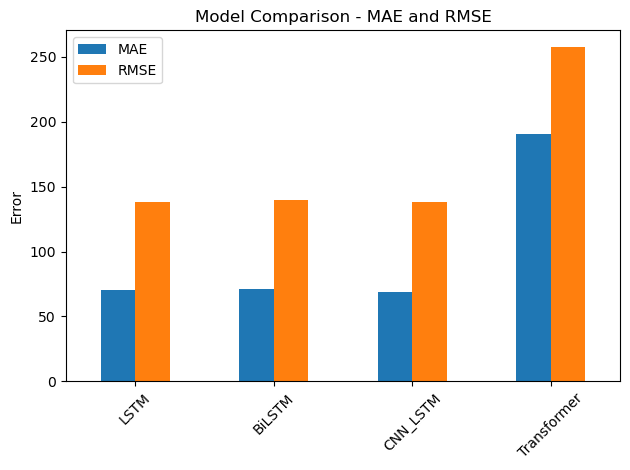

In [16]:
plt.figure(figsize=(10, 6))
results_df[['MAE', 'RMSE']].plot(kind='bar', rot=45)
plt.title('Model Comparison - MAE and RMSE')
plt.ylabel('Error')
plt.tight_layout()
plt.savefig(OUT_DIR / "model_comparison.png")
plt.show()

### Feature importance analysis (for best model)

In [17]:
best_model_name = results_df['MAE'].idxmin()
print(f"\nBest model: {best_model_name}")


Best model: CNN_LSTM


## Visualization

In [18]:
def plot_predictions(y_true, y_pred, model_name):
    """Create comprehensive prediction plots"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Scatter plot
    axes[0,0].scatter(y_true, y_pred, alpha=0.6)
    axes[0,0].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    axes[0,0].set_xlabel('Actual')
    axes[0,0].set_ylabel('Predicted')
    axes[0,0].set_title(f'{model_name} - Actual vs Predicted')
    
    # Residual plot
    residuals = y_pred - y_true
    axes[0,1].scatter(y_pred, residuals, alpha=0.6)
    axes[0,1].axhline(y=0, color='r', linestyle='--')
    axes[0,1].set_xlabel('Predicted')
    axes[0,1].set_ylabel('Residuals')
    axes[0,1].set_title(f'{model_name} - Residual Plot')
    
    # Distribution plot
    axes[1,0].hist(residuals, bins=50, alpha=0.7)
    axes[1,0].axvline(x=0, color='r', linestyle='--')
    axes[1,0].set_xlabel('Residuals')
    axes[1,0].set_ylabel('Frequency')
    axes[1,0].set_title(f'{model_name} - Residual Distribution')
    
    # Error by magnitude
    error_by_magnitude = pd.DataFrame({
        'actual': y_true,
        'absolute_error': np.abs(residuals)
    })
    # Error by magnitude - Versión robusta
    error_by_magnitude = pd.DataFrame({
        'actual': y_true,
        'absolute_error': np.abs(residuals)
    })
    
    # Filtrar valores únicos para evitar el error
    unique_vals = error_by_magnitude['actual'].nunique()
    n_bins = min(10, unique_vals)  # No más bins que valores únicos
    
    if n_bins > 1:
        try:
            error_by_magnitude['magnitude_bin'] = pd.qcut(
                error_by_magnitude['actual'], 
                q=n_bins, 
                duplicates='drop'
            )
        except:
            error_by_magnitude['magnitude_bin'] = pd.cut(
                error_by_magnitude['actual'], 
                bins=n_bins
            )
        
        bin_errors = error_by_magnitude.groupby('magnitude_bin')['absolute_error'].mean()
        
        axes[1,1].bar(range(len(bin_errors)), bin_errors.values)
        axes[1,1].set_xlabel('Actual Value Bins')
        axes[1,1].set_ylabel('Mean Absolute Error')
        axes[1,1].set_title(f'{model_name} - Error by Magnitude')
        axes[1,1].set_xticks(range(len(bin_errors)))
        axes[1,1].set_xticklabels([str(bin) for bin in bin_errors.index], rotation=45)
    else:
        axes[1,1].text(0.5, 0.5, 'Insufficient unique values for binning', 
                      ha='center', va='center', transform=axes[1,1].transAxes)
        axes[1,1].set_title('Error by Magnitude - Not Available')
    
    
    axes[1,1].bar(range(len(bin_errors)), bin_errors.values)
    axes[1,1].set_xlabel('Actual Value Bins')
    axes[1,1].set_ylabel('Mean Absolute Error')
    axes[1,1].set_title(f'{model_name} - Error by Magnitude')
    axes[1,1].set_xticks(range(len(bin_errors)))
    axes[1,1].set_xticklabels([f'Bin {i+1}' for i in range(len(bin_errors))], rotation=45)
    
    plt.tight_layout()
    plt.savefig(OUT_DIR / f"{model_name}_detailed_analysis.png")
    plt.show()

## Conclusion

In [19]:
best_model = models.load_model(OUT_DIR / f"{best_model_name}_model.keras")

/home/e.ladino/miniconda3/envs/e_ladino/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 11 variables whereas the saved optimizer has 20 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


/tmp/ipykernel_1809376/530392836.py:55: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_errors = error_by_magnitude.groupby('magnitude_bin')['absolute_error'].mean()


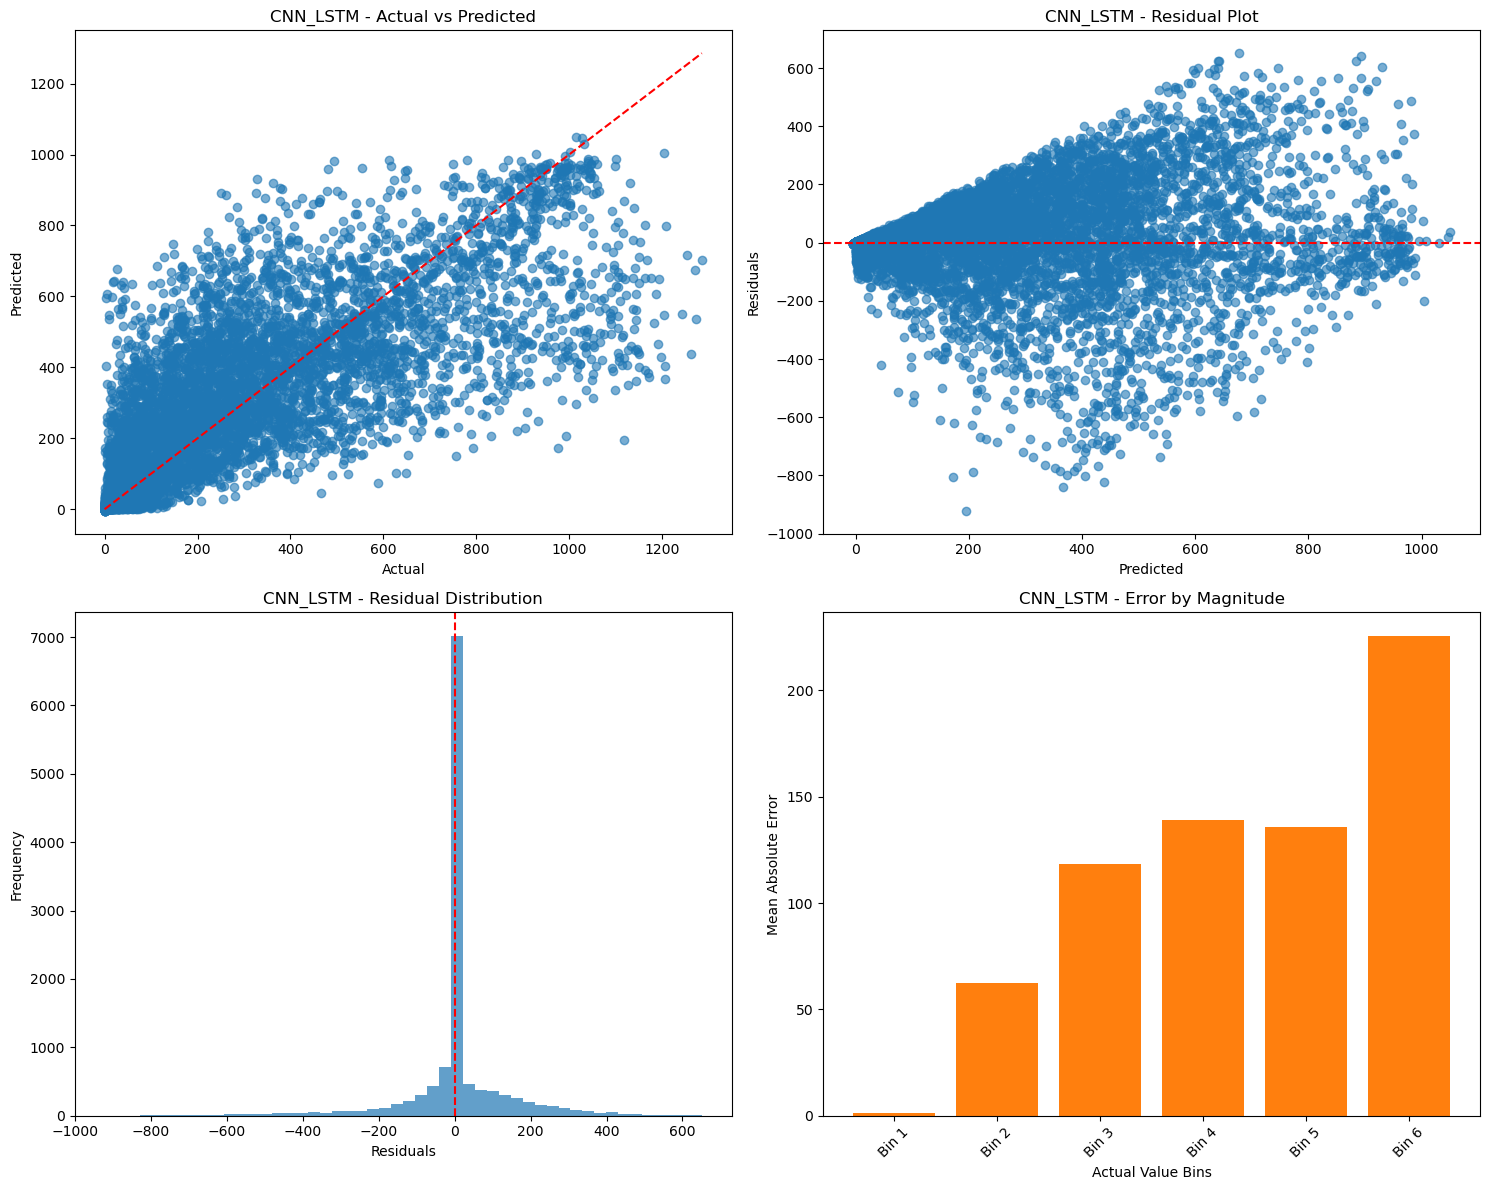


Best model (CNN_LSTM) detailed metrics:
MAE: 68.8909
RMSE: 137.9922
R2: 0.7129
MBE: 5.4957


In [20]:
best_metrics, best_predictions = evaluate_model(best_model, X_test, y_test, f"best_{best_model_name}")
plot_predictions(y_test, best_predictions, best_model_name)

print(f"\nBest model ({best_model_name}) detailed metrics:")
for metric, value in best_metrics.items():
    print(f"{metric}: {value:.4f}")